In [23]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as tdatasets
import umap.umap_ as umap
from sklearn.datasets import fetch_mldata
import seaborn as sns

from fastai import datasets,layers
from fastai.vision import ImageList
from fastai.basic_train import Learner
from fastai.basic_data import DataBunch
from fastai.callback import Callback
from ipdb import set_trace
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from functools import partial
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import torchvision.datasets as tdatasets
import torch.nn as nn
import numpy as np
import hdbscan
import utils
utils.reload()

In [11]:
NZ=30

In [12]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [15]:
mnist=tdatasets.MNIST(root='~/unsupervised_object_learning/data/',train=True,download=True)
print(dir(mnist))
mnist_dataset = utils.get_mnist_dset()

mnist_data,mnist_labels = mnist_dataset.x,mnist_dataset.y
mnist_data = utils.to_float_tensor(mnist_data.view(60000,-1))
mnist_data.shape,mnist_labels.shape

['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', 'download', 'processed_folder', 'raw_folder', 'root', 'target_transform', 'test_file', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'urls']


(torch.Size([60000, 784]), torch.Size([60000]))

In [16]:
umap_embeddings = umap.UMAP(random_state=42).fit_transform(mnist_data)

/home/louis/anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/louis/anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.ht

In [17]:
umap_embeddings.shape

(60000, 2)

In [18]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [19]:
mnist_labels[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], device='cuda:0')

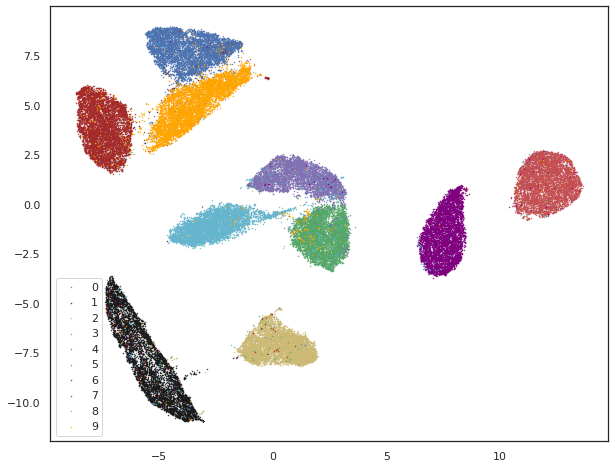

<module 'matplotlib.pyplot' from '/home/louis/anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [24]:
utils.scatter_clusters(umap_embeddings,mnist_labels)

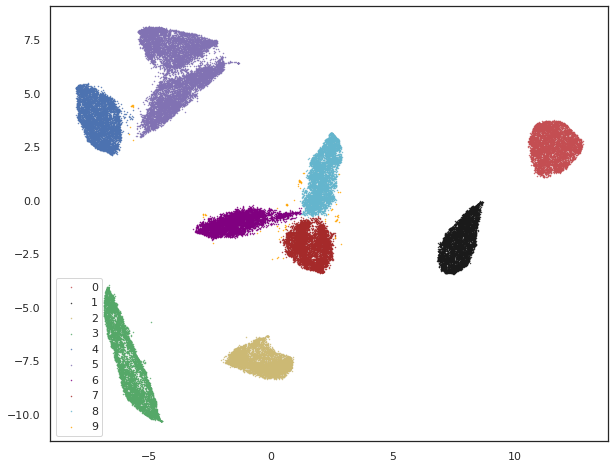

<module 'matplotlib.pyplot' from '/home/louis/anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [29]:
utils.scatter_clusters(clusterable_umap,hdbscan_labels2)

In [ ]:
palette = ['r','k','y','g','b','m','purple','brown','c','orange']

for i in range(10):
    plt.scatter(umap_embeddings[mnist_labels.numpy()==i,0], umap_embeddings[mnist_labels.numpy()==i,1], s=0.1, c=palette[i], label=i)
plt.legend()

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz,ngf,nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def get_reslike_block(nfs,sz):
    return nn.Sequential(
        *[layers.conv_layer(nfs[i],nfs[i+1],stride=2 if i==0 else 1,norm_type='batchnorm_2d',leaky=0.3,padding=1)
         for i in range(len(nfs)-1)], nn.AdaptiveAvgPool2d(sz))

def get_enc_dec():
    block1 = get_reslike_block([1,4,8,16,32],sz=7)
    block2 = get_reslike_block([32,64,128,256,NZ],sz=1)
    enc = nn.Sequential(block1,block2)
    dec = Generator(nz=NZ,ngf=32,nc=1)    
    return enc,dec

def get_enc_dec_mu_var():
    block1 = get_reslike_block([1,4,8,16,32],sz=7)
    block2 = get_reslike_block([32,64,128,256],sz=1)
    mu_net = nn.Linear(256,NZ)
    var_net = nn.Linear(256,NZ)
    enc = nn.Sequential(block1,block2)
    dec = Generator(nz=NZ,ngf=32,nc=1)    
    return enc,dec,mu_net,var_net

In [ ]:
enc,dec = get_enc_dec()

In [ ]:
class AE():
    def __init__(self,enc,dec,dataset,opt,loss_func): 
        self.enc,self.dec,self.dataset,self.loss_func = enc,dec,dataset,loss_func
        self.opt = opt(params = [{'params':enc.parameters()},{'params':dec.parameters()}])
        self.writer = SummaryWriter()
        
    def one_batch(self,xb):
        latent = self.enc(xb)
        pred = self.dec(latent)
        return self.loss_func(pred,xb),pred
      
    @property
    def data(self): 
        dl = data.DataLoader(self.dataset,batch_sampler=data.BatchSampler(data.SequentialSampler(mnist_dataset),len(self.dataset),drop_last=False))
        return next(iter(dl))
    @property
    def latents(self): return self.enc(self.data)
    
    def train(self,epochs,bs):
        dl = data.DataLoader(self.dataset,batch_sampler=data.BatchSampler(data.RandomSampler(mnist_dataset),bs,drop_last=True))
        for epoch in range(epochs):
            for i, xb in enumerate(dl): 
                loss,pred = self.one_batch(xb)
                self.writer.add_scalar('ae/rloss',loss,i)
                loss.backward(); self.opt.step(); self.opt.zero_grad()
            self.writer.add_images('Test_batch',pred,epoch)
            
    def check_ae_images(self,num_rows=5):
        inimgs = self.dataset[:num_rows*4]
        x = self.enc(inimgs)
        outimgs = self.dec(x)
        print(outimgs.shape)
        _, axes = plt.subplots(num_rows,4,figsize=(7,7))
        for i in range(num_rows):
            axes[i,0].imshow(inimgs[i,0])
            axes[i,1].imshow(outimgs[i,0])
            axes[i,2].imshow(inimgs[i+num_rows,0])
            axes[i,3].imshow(outimgs[i+num_rows,0])
            

In [ ]:
ae = AE(enc,dec,mnist_dataset,opt=torch.optim.Adam,loss_func=nn.L1Loss())

In [ ]:
ae.train(epochs=9,bs=256)

In [ ]:
ae.check_ae_images()

In [ ]:
ae_latents = ae.latents[:,:,0,0]

In [ ]:
ae_umap = umap.UMAP(random_state=42).fit_transform(ae_latents)

In [27]:
clusterable_umap = umap.UMAP(min_dist=0, n_neighbors=30,random_state=42).fit_transform(mnist_data)

/home/louis/anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/unsupervised_object_learning/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(ae_latents)

In [28]:
hdbscan_labels2 = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(clusterable_umap)

In [ ]:
hdbscan_labels3 = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(ae_umap)

In [25]:
hdbscan_labels4 = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(umap_embeddings)

In [26]:
clustered = hdbscan_labels4>=0
hdbscan_labels4[clustered]
clustered

array([ True,  True,  True,  True, ...,  True,  True,  True,  True])

In [ ]:
for i in range(10):
    plt.scatter(ae_umap[hdbscan_labels4==i,0], ae_umap[hdbscan_labels4==i,1], s=0.1, c=palette[i], label=i)
plt.scatter(ae_umap[~clustered,0],ae_umap[~clustered,1],c=[0.5,0.5,0.5],s=0.1)
plt.legend()

In [ ]:
for i in range(10):
    plt.scatter(ae_umap[hdbscan_labels2==i,0], ae_umap[hdbscan_labels2==i,1], s=0.1, c=palette[i], label=i)
plt.scatter(ae_umap[~clustered,0],ae_umap[~clustered,1],c=[0.5,0.5,0.5],s=0.1)
plt.legend()

In [ ]:
len(mnist_labels.numpy()[clustered])

In [ ]:
adjusted_rand_score(hdbscan_labels[clustered],mnist_labels.numpy()[clustered]),adjusted_mutual_info_score(hdbscan_labels[clustered],mnist_labels.numpy()[clustered])

In [ ]:
palette = ['r','k','y','g','b','m','purple','brown','c','orange']

for i in range(10):
    plt.scatter(ae_umap[mnist_labels.numpy()==i,0], ae_umap[mnist_labels.numpy()==i,1], s=0.1, c=palette[i], label=i)
plt.legend()

In [ ]:
def plot_mnist(mnist_vecs):
    umapped = umap.UMAP(random_state=42).fit_transform(mnist_vecs)
    palette = ['r','k','y','g','b','m','purple','brown','c','orange']
    labels = mnist_labels.numpy()
    for i in range(10):
        plt.scatter(umapped[mnist_labels==i,0], umapped[mnist_labels==i,1], s=0.1, c=palette[i], label=i)
    plt.legend()